In [1]:
import pandas as pd

In [2]:
url = "https://docs.google.com/spreadsheets/d/1vFWwNJ7-61O_QYaPo8d7bmw7K192az4R/export"
data_excel = pd.read_excel(url, sheet_name=0, header=9)
data_excel = data_excel.iloc[:, :-11]

In [3]:
#Obtengo las columnas que me interesan
#data = data.iloc[:, -10:]
col_sexo = data_excel.iloc[:, 0]
col_baremos = data_excel.iloc[:, -11:]

data  = pd.concat( [col_sexo, col_baremos], axis=1 )
data.head()

,Sexo,Somatización,Obsesión/com,Sen. Emocio.,Depresión,Ansiedad,Hostilidad,Ans. Fóbica,Ideación Paran.,Psicoticismo,Agotamiento,SA45
0,1,Promedio,Alto,Bajo,Promedio,Promedio,Promedio,Bajo,Bajo,Promedio,Bajo,Bajo
1,1,Alto,Promedio,Bajo,Alto,Promedio,Bajo,Promedio,Alto,Bajo,Bajo,Bajo
2,1,Bajo,Promedio,Promedio,Bajo,Bajo,Promedio,Bajo,Alto,Bajo,Alto,Bajo
3,1,Alto,Alto,Alto,Alto,Alto,Alto,Promedio,Alto,Bajo,Alto,Promedio
4,1,Promedio,Bajo,Alto,Alto,Promedio,Bajo,Alto,Alto,Bajo,Bajo,Bajo


In [4]:
#Creo el map
category_map = {
    'Bajo': 0,
    'Promedio': 1,
    'Alto': 2
}

In [5]:
#Convierto las categorias a numeros
data2 = data.copy()
for i in range(11):
    data2.iloc[:, 1+i ] = data2.iloc[:, 1+i ].map(category_map)

data2.head()

,Sexo,Somatización,Obsesión/com,Sen. Emocio.,Depresión,Ansiedad,Hostilidad,Ans. Fóbica,Ideación Paran.,Psicoticismo,Agotamiento,SA45
0,1,1,2,0,1,1,1,0,0,1,0,0
1,1,2,1,0,2,1,0,1,2,0,0,0
2,1,0,1,1,0,0,1,0,2,0,2,0
3,1,2,2,2,2,2,2,1,2,0,2,1
4,1,1,0,2,2,1,0,2,2,0,0,0


In [6]:
data2.to_csv("respuestas_label.csv")

In [7]:
#Importo Pycaret para clasificacion
from pycaret.classification import *

In [8]:
clf = setup(data2, target='Agotamiento', session_id=123, fold=4)

,Description,Value
0,Session id,123
1,Target,Agotamiento
2,Target type,Multiclass
3,Original data shape,"(372, 12)"
4,Transformed data shape,"(372, 32)"
5,Transformed train set shape,"(260, 32)"
6,Transformed test set shape,"(112, 32)"
7,Numeric features,1
8,Categorical features,10
9,Preprocess,True


In [9]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [10]:
# init setup on exp
exp.setup(data2, target = 'Agotamiento', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Agotamiento
2,Target type,Multiclass
3,Original data shape,"(372, 12)"
4,Transformed data shape,"(372, 32)"
5,Transformed train set shape,"(260, 32)"
6,Transformed test set shape,"(112, 32)"
7,Numeric features,1
8,Categorical features,10
9,Preprocess,True


In [11]:
# compare baseline models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6577,0.0000,0.6577,0.6741,0.6536,0.4714,0.4824,0.0675
lda,Linear Discriminant Analysis,0.6538,0.0000,0.6538,0.6715,0.6494,0.4656,0.4765,0.0575
lr,Logistic Regression,0.6500,0.0000,0.6500,0.6639,0.6465,0.4574,0.4660,0.8450
lightgbm,Light Gradient Boosting Machine,0.6423,0.7810,0.6423,0.6493,0.6378,0.4389,0.4451,0.2025
rf,Random Forest Classifier,0.6385,0.7805,0.6385,0.6380,0.6325,0.4301,0.4340,0.1300
knn,K Neighbors Classifier,0.6346,0.7436,0.6346,0.6365,0.6329,0.4325,0.4346,0.6950
svm,SVM - Linear Kernel,0.6346,0.0000,0.6346,0.6608,0.6281,0.4425,0.4556,0.0650
gbc,Gradient Boosting Classifier,0.6346,0.0000,0.6346,0.6415,0.6299,0.4275,0.4331,0.1750
ada,Ada Boost Classifier,0.6115,0.0000,0.6115,0.6132,0.6060,0.3977,0.4023,0.0975
et,Extra Trees Classifier,0.6115,0.7594,0.6115,0.6113,0.6082,0.3928,0.3949,0.1250


In [12]:
best2 = exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6577,0.7946,0.6577,0.6658,0.6517,0.4618,0.4714,0.2190
lr,Logistic Regression,0.6538,0.0000,0.6538,0.6594,0.6485,0.4607,0.4672,0.0620
ridge,Ridge Classifier,0.6538,0.0000,0.6538,0.6690,0.6485,0.4653,0.4750,0.0620
lda,Linear Discriminant Analysis,0.6500,0.0000,0.6500,0.6597,0.6451,0.4610,0.4682,0.0590
rf,Random Forest Classifier,0.6423,0.7755,0.6423,0.6469,0.6364,0.4359,0.4423,0.1220
gbc,Gradient Boosting Classifier,0.6346,0.0000,0.6346,0.6339,0.6259,0.4205,0.4264,0.1640
et,Extra Trees Classifier,0.6308,0.7568,0.6308,0.6343,0.6240,0.4207,0.4270,0.1120
knn,K Neighbors Classifier,0.6192,0.7520,0.6192,0.6279,0.6165,0.4138,0.4187,0.0650
ada,Ada Boost Classifier,0.6115,0.0000,0.6115,0.6245,0.6061,0.4016,0.4094,0.0950
nb,Naive Bayes,0.5769,0.7562,0.5769,0.5874,0.5580,0.3623,0.3781,0.0640


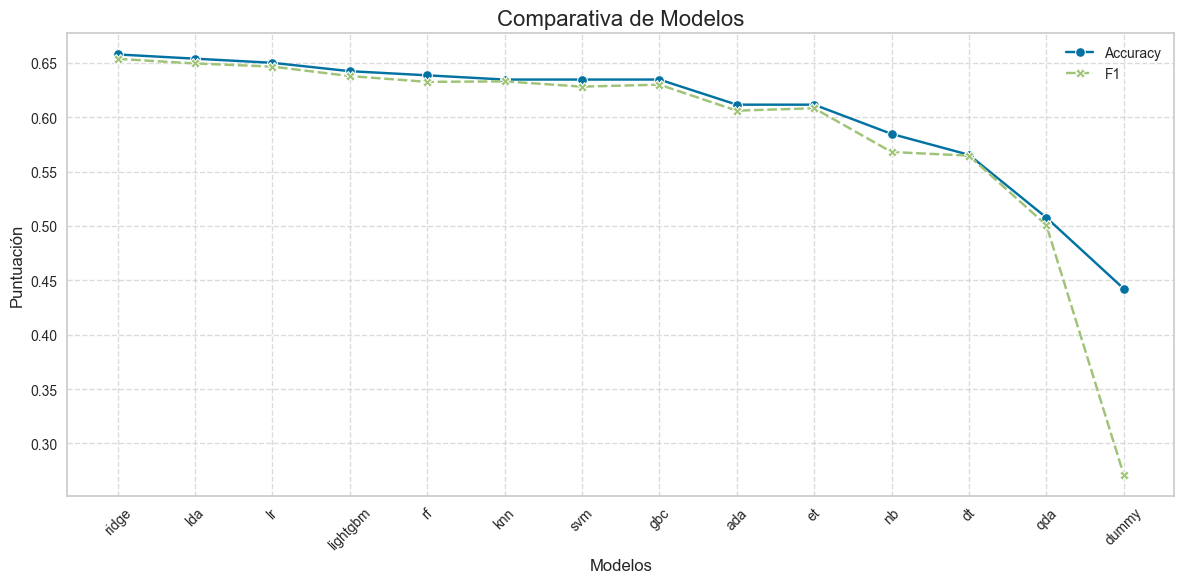

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtén los resultados de comparación como un DataFrame
comparison_df = pull()

# Filtra las métricas que quieres graficar
metrics_to_plot = ['Accuracy', 'F1']  # Asegúrate de que los nombres coincidan con los del DataFrame
filtered_df = comparison_df[metrics_to_plot]

# Configura el gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, markers=True)

# Configura etiquetas y título
plt.title("Comparativa de Modelos", fontsize=16)
plt.xlabel("Modelos", fontsize=12)
plt.ylabel("Puntuación", fontsize=12)
plt.xticks(ticks=range(len(comparison_df.index)), labels=comparison_df.index, rotation=45)
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Muestra el gráfico
plt.tight_layout()
plt.show()



In [14]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

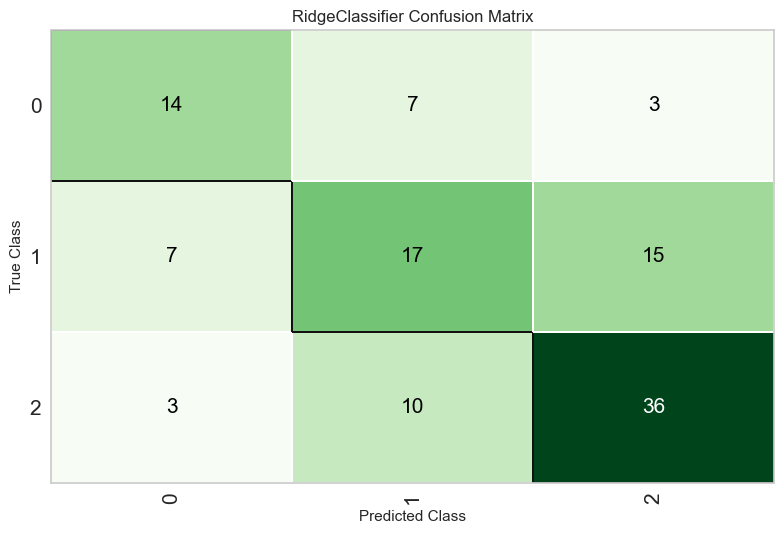

In [15]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

In [16]:
tuned_ridge = tune_model(create_model('ridge', verbose=False), n_iter=200)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6615,0.0000,0.6615,0.6886,0.6663,0.4836,0.4905
1,0.6615,0.0000,0.6615,0.6580,0.6580,0.4670,0.4686
2,0.5846,0.0000,0.5846,0.6059,0.5853,0.3707,0.3774
3,0.7538,0.0000,0.7538,0.7799,0.7389,0.6078,0.6359
Mean,0.6654,0.0000,0.6654,0.6831,0.6621,0.4823,0.4931
Std,0.0600,0.0000,0.0600,0.0632,0.0544,0.0843,0.0927


Fitting 4 folds for each of 200 candidates, totalling 800 fits


In [17]:
final_model = finalize_model(tuned_ridge)

predictions = predict_model(final_model, data=data2)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.6828,0,0.6828,0.6798,0.6796,0.5048,0.5062


,Sexo,Somatización,Obsesión/com,Sen. Emocio.,Depresión,Ansiedad,Hostilidad,Ans. Fóbica,Ideación Paran.,Psicoticismo,SA45,Agotamiento,prediction_label
0,1,1,2,0,1,1,1,0,0,1,0,0,1
1,1,2,1,0,2,1,0,1,2,0,0,0,1
2,1,0,1,1,0,0,1,0,2,0,0,2,0
3,1,2,2,2,2,2,2,1,2,0,1,2,2
4,1,1,0,2,2,1,0,2,2,0,0,0,1


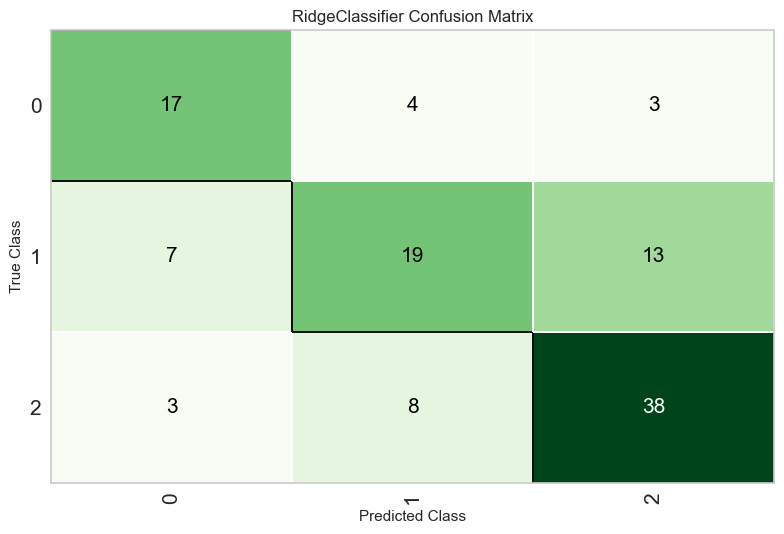

In [18]:
plot_model(final_model, plot='confusion_matrix')

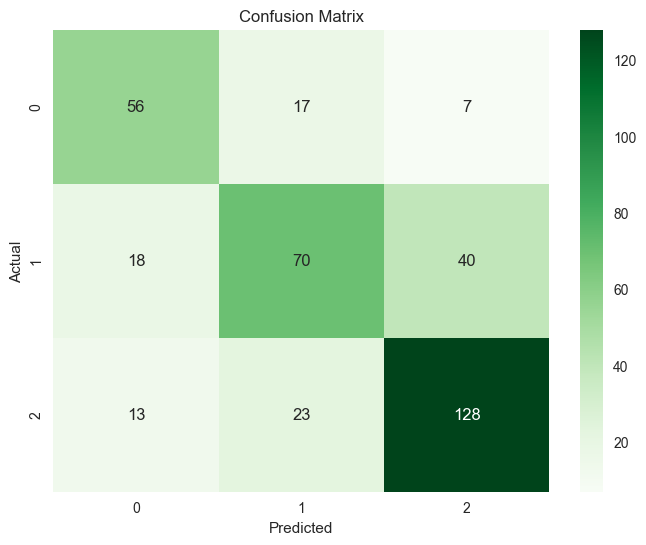

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las etiquetas reales y predichas
y_true = data2['Agotamiento'].astype(int)  # Reemplaza 'target_column' con el nombre de la columna objetivo
y_pred = predictions['prediction_label'].astype(int)   # PyCaret genera la columna 'Label' con las predicciones

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=final_model.classes_, yticklabels=final_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [20]:
from pycaret.classification import save_model

# Guardar el modelo entrenado
save_model(final_model, 'modelo-SA45-ECE_Sexo_SA45-total')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['Sexo'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Somatización', 'Obsesión/com',
                                              'Sen....
                                                               return_df=True,
                                                      